# Build a Handbags-Shoes Classifier with Transfer Learning - Finetune a Pretrained Vision Transformer

Credit: Some of the data preprocessing code adapted from [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?gclid=CjwKCAjw9aiIBhA1EiwAJ_GTSlKgxc4qopKHPsFWryOoTz7fvhvhzYSjEsgQ-bG1R51QSGppISywpBoClcIQAvD_BwE) by Francois Chollett

## Introduction

In this colab we will **fine tune a pretrained model (i.e., we will do Transfer Learning)** to build a highly accurate image classification model with very little data. Pretty much any consumer-facing app that uses image AI was probably built using this technique.

We also show how to use a technique called **data augmentation** to increase the size of your image dataset.

## Usual Setup

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # jax is often faster than tensorflow so let's try it!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras

keras.utils.set_random_seed(42)

## Data Preprocessing

Let's grab the shoe-handbag dataset

In [ ]:
!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip

In [ ]:
!unzip -qq handbags-shoes.zip

replace handbags-shoes/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace handbags-shoes/shoes/17. 81ezvumxbtl._cb1525212597_.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os, shutil, pathlib
base_dir = pathlib.Path("/content/handbags-shoes")

In [ ]:
for category in ('handbags', 'shoes'):
  fnames = os.listdir(base_dir/category)

  dir = base_dir /'train' / category
  os.makedirs(dir, exist_ok=True)
  for fname in fnames[:50]:    # the first 50 examples go into the training set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

  dir = base_dir /'validation' / category
  os.makedirs(dir, exist_ok=True)
  for fname in fnames[50:75]:  # the next 25 examples go into the validation set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

  dir = base_dir /'test' / category
  os.makedirs(dir, exist_ok=True)
  for fname in fnames[75:]:    # the remaining examples go into the test set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

The code above creates this directory structure:

train/   
..handbags/         
..shoes/    
validation/    
..handbags/       
..shoes/         
test/    
..handbags/     
..shoes/   

You can see this for yourself by clicking on the folder icon on the left nav bar.

When working with image JPEGs, we will follow this process:

1.   Read in the JPEGs
2.   Convert the JPEGs into tensors
3.   Resize them to a standard size (since web-scraped images may be in different sizes)
5.   Group them into batches (we’ll use batches of 32 images).


Fortunately, Keras gives us a single function that does all these in one shot! (Ref: [image manipulation functions](https://keras.io/api/preprocessing/image/))

In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)


Found 98 files belonging to 2 classes.
Found 48 files belonging to 2 classes.
Found 39 files belonging to 2 classes.



Is "Deep Learning" even possible with so few examples?

YES!

We will now build a near-perfect handbags vs shoes classifier using **just** these 200 images!


Let's check the shape of each image. Since these are color images, they will have 3 channels and since we sized them to (224, 224) 👆, the shape should be (224, 224, 3).

In [ ]:
for images, _ in train_dataset.take(1):
  print(images[0].shape)

(224, 224, 3)


Image shape: (224, 224, 3)
Red channel min: 9, max: 255
Green channel min: 7, max: 255
Blue channel min: 2, max: 255


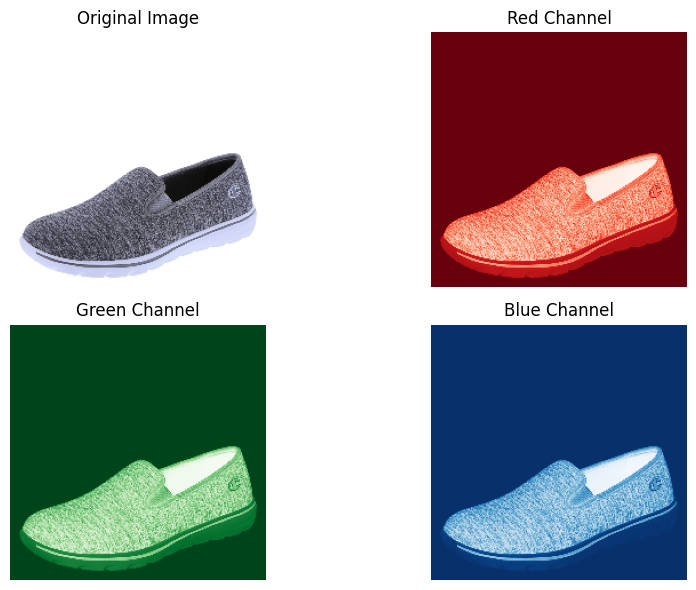

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first image from the dataset
for images, _ in train_dataset.take(1):
    image = images[0].numpy().astype("uint8")
    break

# Print image shape
print(f"Image shape: {image.shape}")

# Extract each channel
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Print unique values in each channel to get a sense of the data
print(f"Red channel min: {red_channel.min()}, max: {red_channel.max()}")
print(f"Green channel min: {green_channel.min()}, max: {green_channel.max()}")
print(f"Blue channel min: {blue_channel.min()}, max: {blue_channel.max()}")

# Visualize the original image and its channels
plt.figure(figsize=(10, 6))

# Original image
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# Red channel
plt.subplot(2, 2, 2)
plt.title("Red Channel")
plt.imshow(red_channel, cmap='Reds')
plt.axis("off")

# Green channel
plt.subplot(2, 2, 3)
plt.title("Green Channel")
plt.imshow(green_channel, cmap='Greens')
plt.axis("off")

# Blue channel
plt.subplot(2, 2, 4)
plt.title("Blue Channel")
plt.imshow(blue_channel, cmap='Blues')
plt.axis("off")

plt.tight_layout()
plt.show()

Nice. Lets take a peek at the images as well.

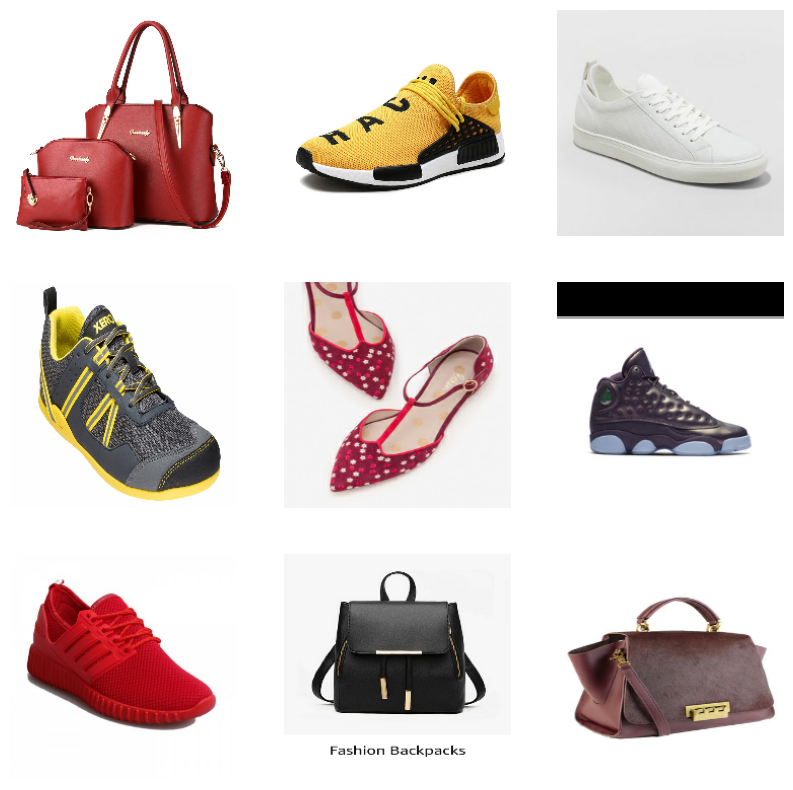

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Data Augmentation for Images

The basic idea of augmentation is to slightly alter the image so that the value of the dependent variable (i.e. the category that it belongs to) doesn't change. For instance, if you rotate the image of a handbag by 10 degrees or zoom in on it slightly, the content of the image doesn't change; it is *still* a handbag.

By applying these transformations repeatedly to an image, you can create new images and thereby increase the size of the dataset almost effortlessly.

Researchers have developed a list of these transformations that you can apply to images and Keras provides them out of the box as different kinds of *layers*.



---



---



To demonstrate, here's a little function that applies three transformations to an incoming image.


In [ ]:
def augment_data(image):
  # Define data augmentation pipeline
  data_augmentation = keras.Sequential([
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.1),
      keras.layers.RandomTranslation(0.1, 0.1),
  ])
  return data_augmentation(image)

Let's apply it to an image from our training set to see what it produces.

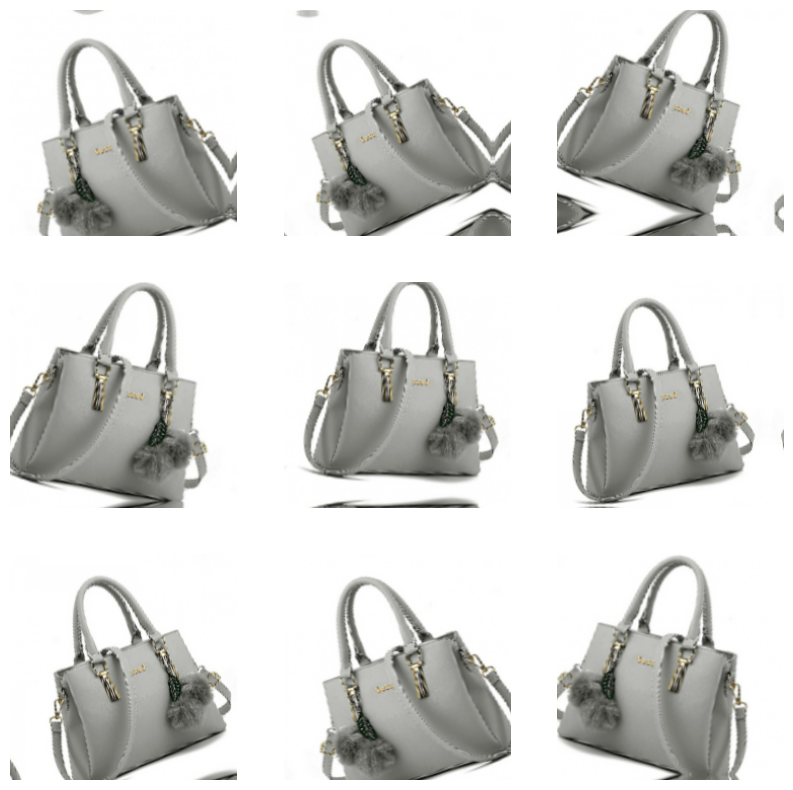

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_data(images[0])
    plt.imshow(np.array(augmented_image).astype("uint8"))
    plt.axis("off")

We can insert these  data augmentation layers right after the input layer in the model we build, and train the model. Because we have effectively more data now, we can train this data-augmented model for more epochs at a lower risk of overfitting.

## Finetuning/ Transfer Learning

We will work with a pre-trained Vision Transformer (ViT) that has been trained on the ImageNet dataset.

(TODO - smooth the flow here) Check out all the pre-trained models available on the [Keras Hub](https://www.kaggle.com/models?tfhub-redirect=true).

The `keras_hub` that comes pre-installed colab isn't up-to-date, so let's get the current version.

In [ ]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
import keras_hub

Here is the configuration of the backbone we will be using:

In [ ]:
config = {
  "module": "keras_hub.src.models.vit.vit_backbone",
  "class_name": "ViTBackbone",
  "config": {
    "name": "vi_t_backbone",
    "trainable": True,
    "image_shape": [
      224,
      224,
      3
    ],
    "patch_size": 16,
    "num_layers": 12,
    "num_heads": 12,
    "hidden_dim": 768,
    "mlp_dim": 3072,
    "dropout_rate": 0,
    "attention_dropout": 0,
    "layer_norm_epsilon": 0.000001,
    "use_mha_bias": True,
    "use_mlp_bias": True
  },
  "registered_name": "keras_hub>ViTBackbone"
}

As you can see this transformer has:
* 12 layers (or "blocks")
* 12 self-attention heads in each layer
* 3072 ReLu neurons inside the feedforward network
* Embedding dimension of 768

A pretty hefty model!

We define our model next. Notice that what we are doing is conceptually quite simple:

1. We take the output of the pre-trained ViT backbone (what is the dimension?)
2. We project this output down to a single vector (or 1D tensor)
3. We pass this vector through a classifier.  

In [ ]:
# We download the ViT preprocessor and the backbone

preprocessor = keras_hub.models.ViTImageClassifierPreprocessor.from_preset(
    "vit_base_patch16_224_imagenet"
)

backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")


100%|██████████| 593/593 [00:00<00:00, 1.18MB/s]


100%|██████████| 1.65k/1.65k [00:00<00:00, 2.96MB/s]


100%|██████████| 328M/328M [00:22<00:00, 15.6MB/s]


The preprocessor does a few things. For example:
* It resizes the images to match the size of the images on which the ViT model was pretrained
* It normalizes the pixel values to match the normalization used when the ViT model was pretrained

Next, we define the data augmentation pipeline.

In [ ]:
# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

Now we are ready to put our model together with these Lego blocks.

**Note**: The output from a ViT backbone typically has shape:

`[batch_size, sequence_length, hidden_dimension]`



In [ ]:
inputs = keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)                             # Apply data augmentation
x = preprocessor(x)                                       # Preprocess input for ViT
x = backbone(x)[:, 0, :]                                  # Run through ViT backbone, select CLS embedding
x = keras.layers.Dense(256, activation="relu")(x)         # Run through a dense layer
outputs = keras.layers.Dense(1, activation="sigmoid")(x)  # Final binary classification layer

# Create the model
model = keras.Model(inputs, outputs)

# Summary of the model
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,995,777 (328.05 MB)

 Trainable params: 85,995,777 (328.05 MB)

 Non-trainable params: 0 (0.00 B)

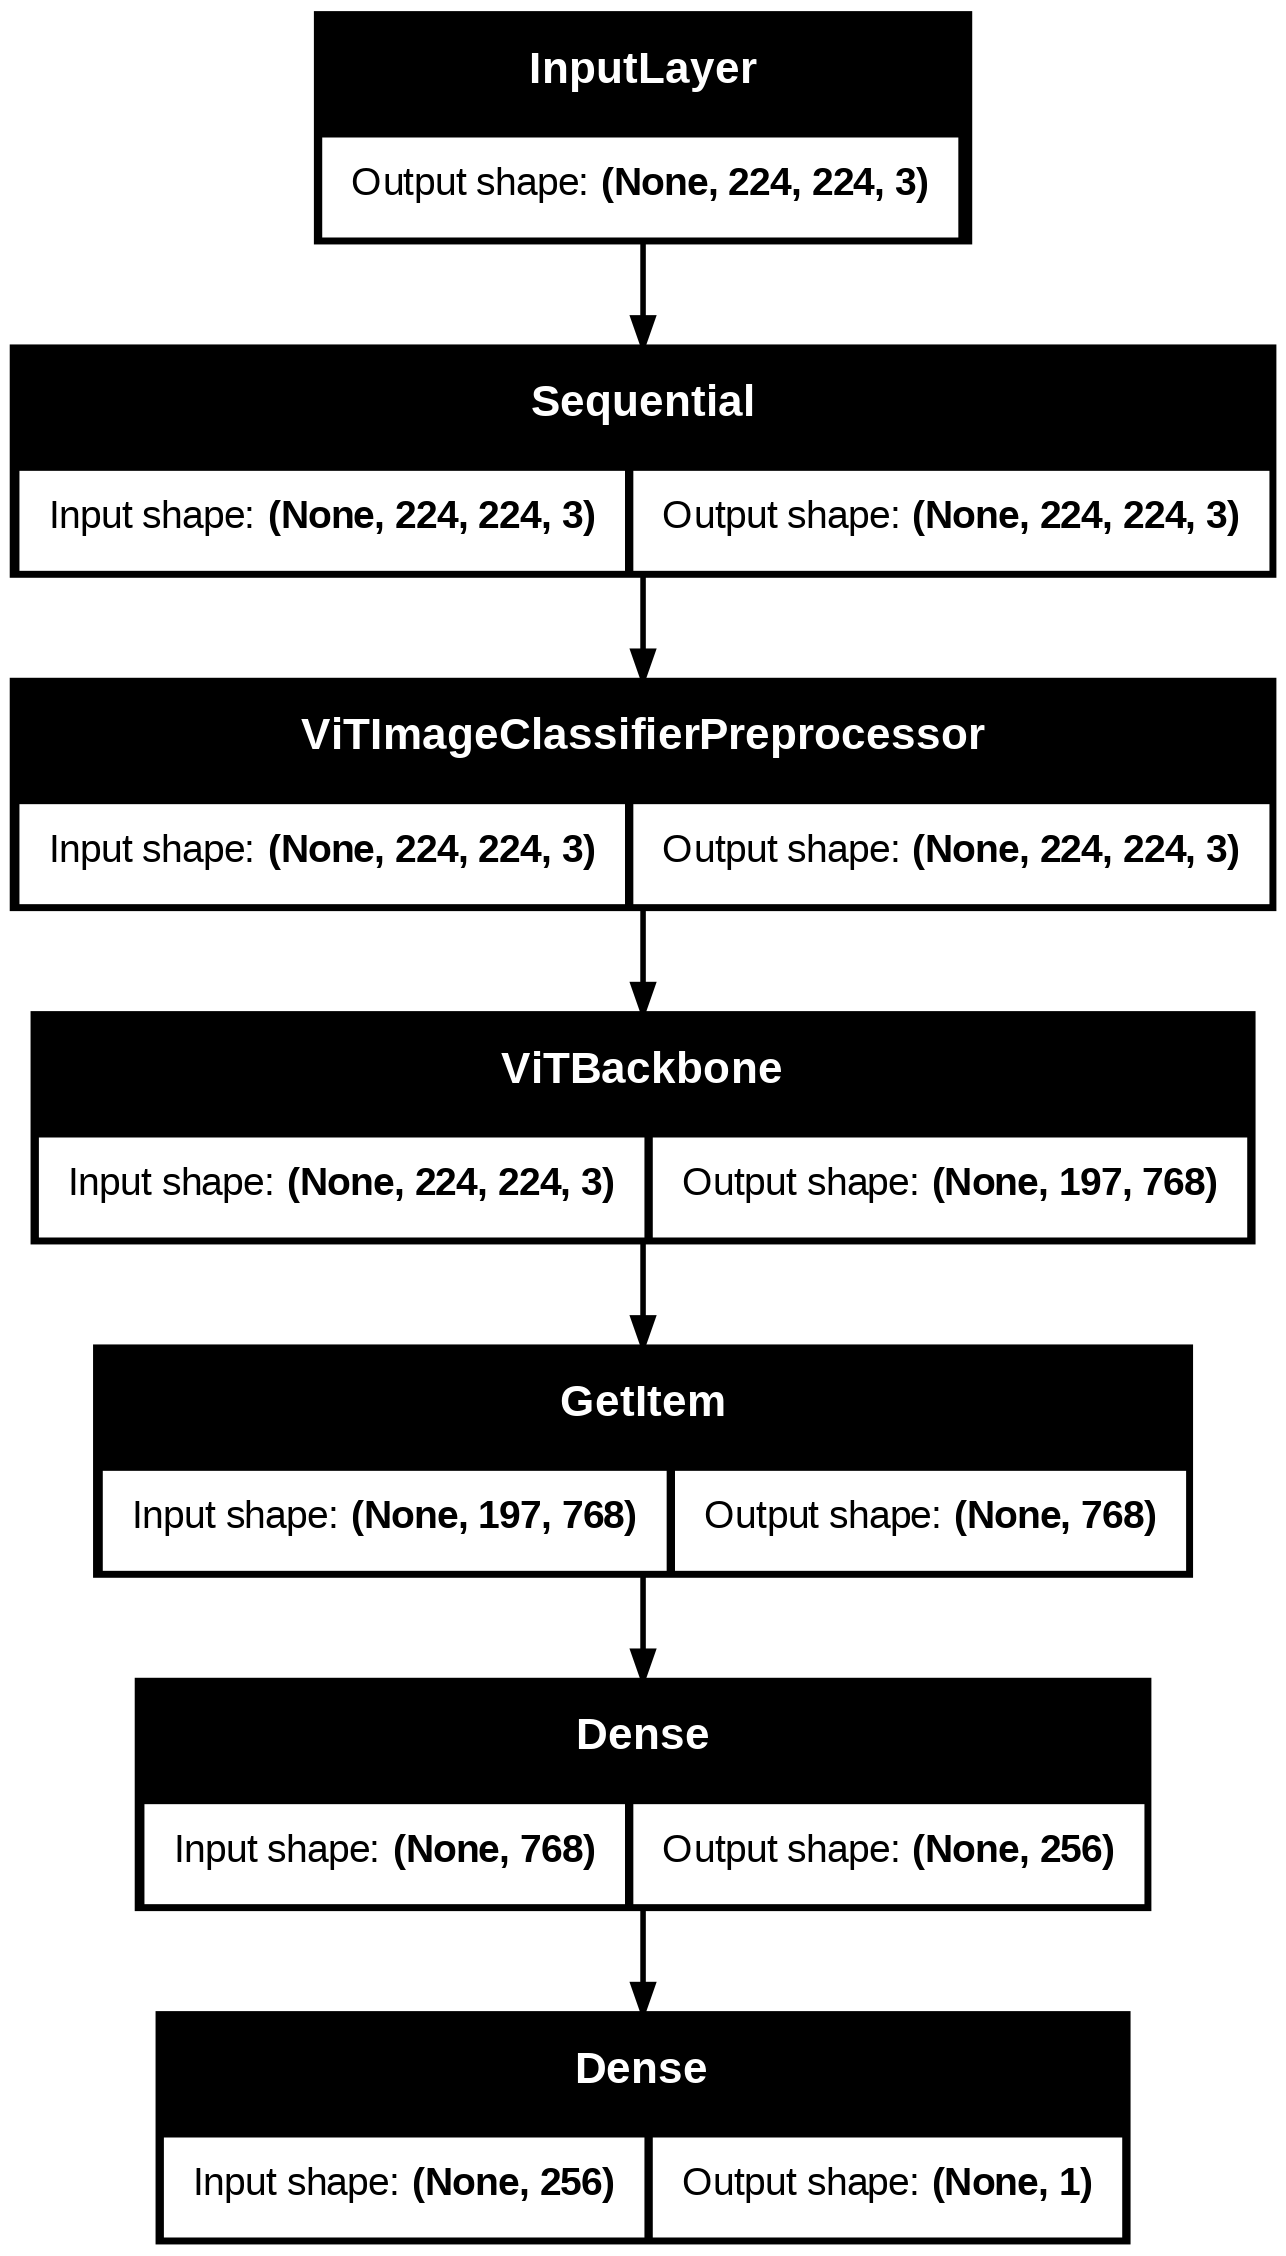

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

We will only train the projection and classifier portions of the model we just defined. We will "freeze" the weights in the backbone so that SGD/Adam won't touch them.

In [ ]:
# Freeze the backbone
backbone.trainable = False

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,995,777 (328.05 MB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

Notice the number of trainable params drops to just 197,121!

In which layers do these params "live"?

Okay, lets train this thing.

In [ ]:
# Compile the model for initial training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Train
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    batch_size=32
)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.4648 - loss: 1.0882 - val_accuracy: 0.7500 - val_loss: 0.5495
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.6526 - loss: 0.6130 - val_accuracy: 0.9167 - val_loss: 0.3159
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.8190 - loss: 0.3702 - val_accuracy: 0.9583 - val_loss: 0.1973
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 585ms/step - accuracy: 0.9597 - loss: 0.2320 - val_accuracy: 1.0000 - val_loss: 0.1325
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - accuracy: 0.9689 - loss: 0.1947 - val_accuracy: 1.0000 - val_loss: 0.0936


In [ ]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.1142


[0.11189963668584824, 1.0]

**IMPRESSIVE ACCURACY ON THE TEST SET!!**


Let's pause for a moment to reflect on what we have done.

We have built an amazingly accurate handbags or shoes classifier with *just* 100 training images!

That's the power of transfer learning!!

## Visual Check of Predictions

OK, let's sample a few test images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


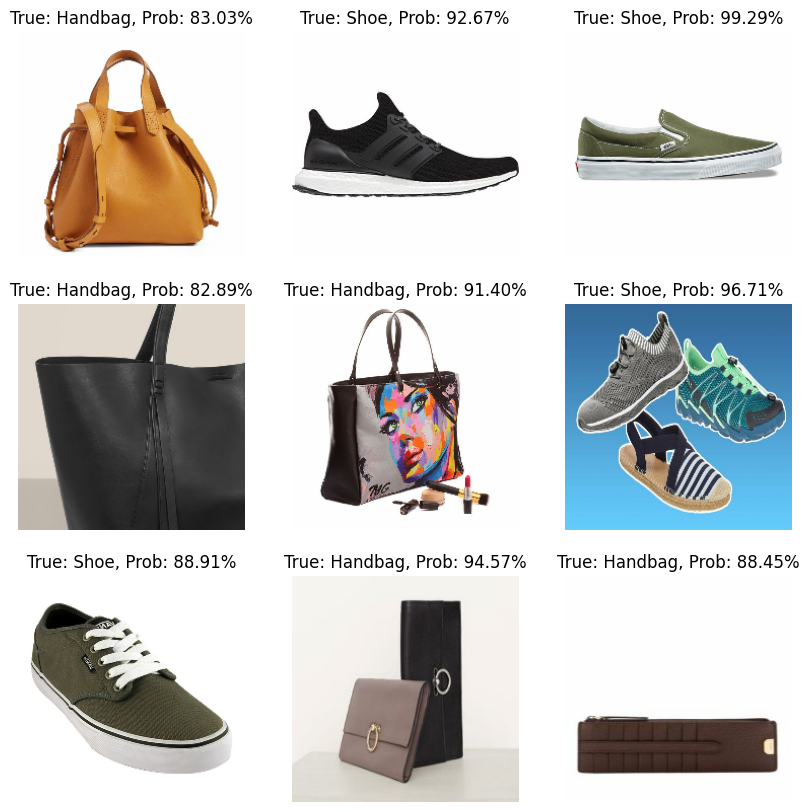

In [ ]:
label_lookup = {0: "Handbag", 1: "Shoe"}

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  preds = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(f"True: {label_lookup[labels[i].numpy()]}, Prob: {max(preds[i,0],1-preds[i,0]):.2%}")
    plt.axis("off")

## Live Demo 🤞

OK, let's test it **LIVE** with my laptop's webcam.

First, a little function to take in an image, run it through the model and pretty-print the result.

In [ ]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = np.expand_dims(arr, axis=0)
  pred = model.predict(arr)
  print(f"Predicted probability = {max(pred[0,0],1-pred[0,0]):.2%}")
  pred = "SHOE" if pred[0,0] > 0.5 else "HANDBAG"
  print("************************************\n\n")
  print(f"...........it is a {pred}!")
  print("\n\n************************************\n\n")

In [ ]:
# Camera Capture code snippet courtesy Google Colab


from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [ ]:
# Camera Capture code snippet courtesy Google Colab

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotAllowedError: Permission denied


In [ ]:
# Camera Capture code snippet courtesy Google Colab

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

name 'take_photo' is not defined


**THE END**

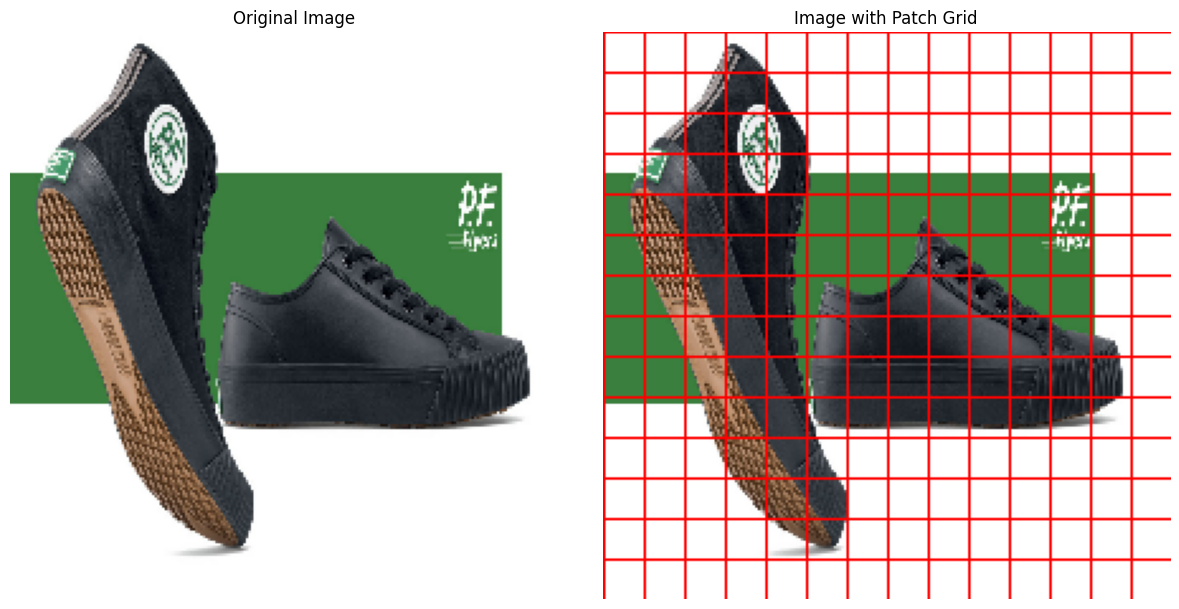

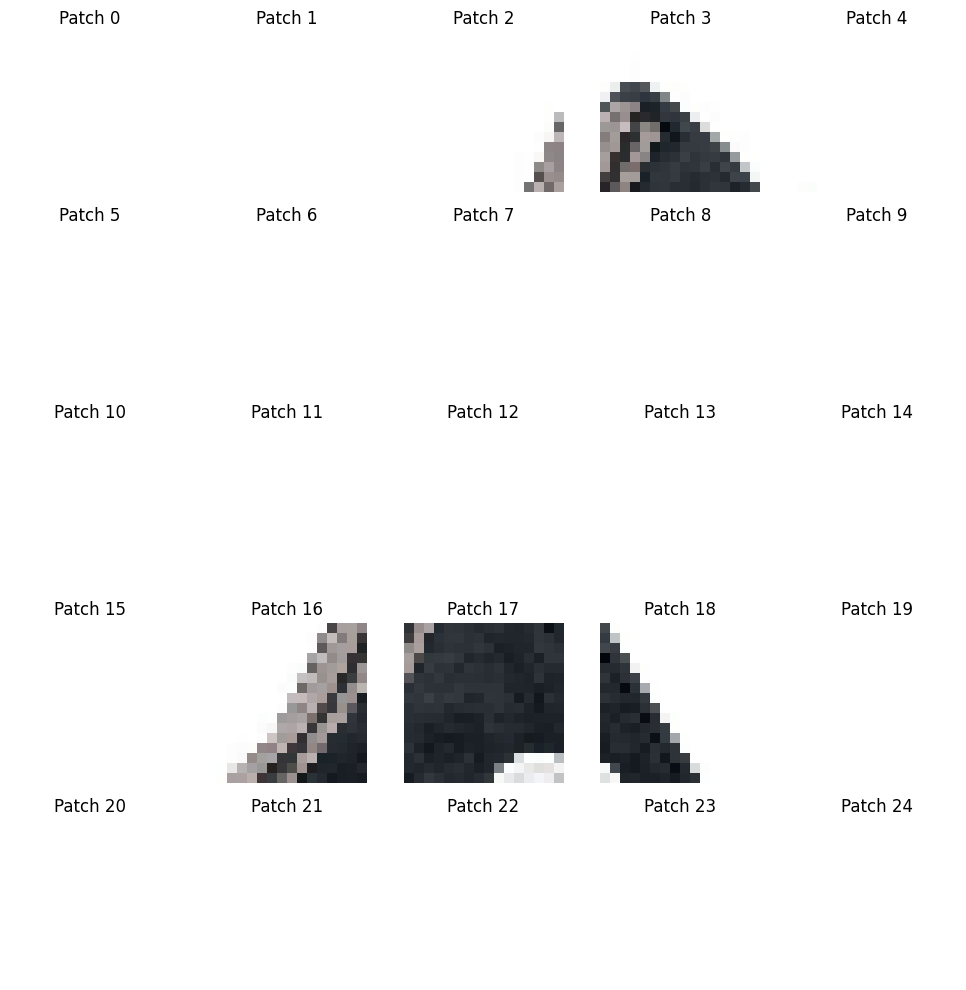

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import math

# Get a sample image from the dataset
for images, _ in train_dataset.take(1):
    sample_image = images[0].numpy().astype("uint8")
    break

# Define ViT patch size
patch_size = 16  # Standard patch size for ViT base

# Function to display the image with patch grid overlay
def show_image_with_patches(image, patch_size):
    # Create a copy of the image
    img_with_grid = image.copy()

    # Draw horizontal lines
    for i in range(0, image.shape[0], patch_size):
        img_with_grid[i:i+1, :, :] = [255, 0, 0]

    # Draw vertical lines
    for i in range(0, image.shape[1], patch_size):
        img_with_grid[:, i:i+1, :] = [255, 0, 0]

    return img_with_grid

# Create patches manually to visualize
def create_patches(image, patch_size):
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            if i + patch_size <= image.shape[0] and j + patch_size <= image.shape[1]:
                patch = image[i:i+patch_size, j:j+patch_size, :]
                patches.append(patch)
    return patches

# Get the patches
patches = create_patches(sample_image, patch_size)
num_patches = len(patches)
grid_size = int(math.sqrt(num_patches))

# Visualize the original image with patch grid
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(show_image_with_patches(sample_image, patch_size))
plt.title("Image with Patch Grid")
plt.axis("off")

plt.tight_layout()
plt.show()

# Display some of the patches
plt.figure(figsize=(10, 10))
for i in range(min(25, len(patches))):
    plt.subplot(5, 5, i + 1)
    plt.imshow(patches[i].astype(np.uint8))  # Ensure correct datatype
    plt.title(f"Patch {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:

# Now, let's get the actual embeddings from the ViT model
# First, preprocess the image
preprocessor = keras_hub.models.ViTImageClassifierPreprocessor.from_preset(
    "vit_base_patch16_224_imagenet"
)
backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")



Embeddings shape: (1, 197, 768)
Embedding dimensions per patch: 768
After PCA, dimensions per patch: 3
Variance explained by 3 PCA components: 50.97%


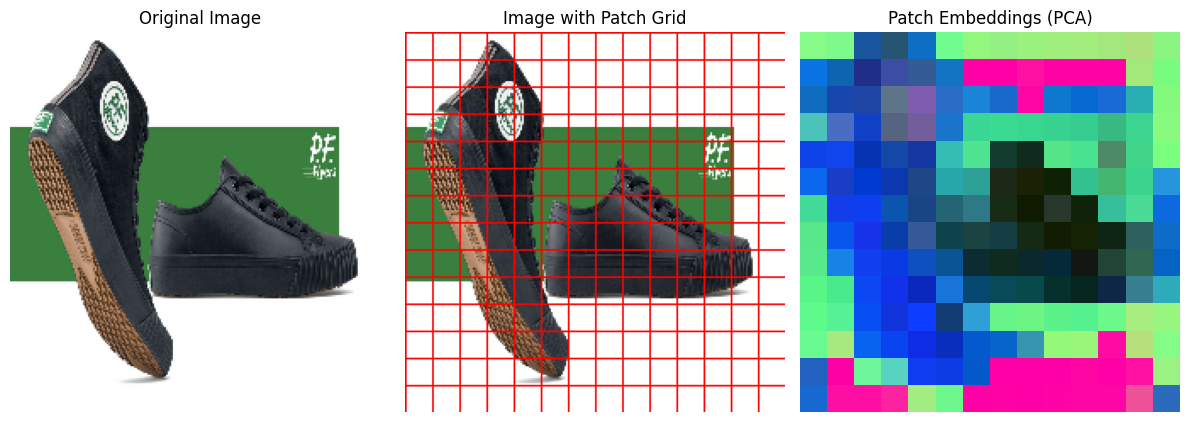

In [ ]:


# Function to visualize embeddings (dimensionality reduction with PCA)
def visualize_embeddings(embeddings, num_patches):
    from sklearn.decomposition import PCA

    # Reshape embeddings to have one embedding per patch
    embeddings_reshaped = embeddings[0, 1:, :]  # Skip the CLS token (first token)

    # Each patch now has a 768-dimensional embedding
    print(f"Embedding dimensions per patch: {embeddings_reshaped.shape[1]}")

    # Apply PCA to reduce dimensions from 768 to just 3
    pca = PCA(n_components=3)
    embeddings_pca = pca.fit_transform(embeddings_reshaped)

    print(f"After PCA, dimensions per patch: {embeddings_pca.shape[1]}")
    print(f"Variance explained by 3 PCA components: {sum(pca.explained_variance_ratio_):.2%}")

    # Now convert these 3 values per patch to RGB colors (0-255)
    embeddings_rgb = (embeddings_pca - embeddings_pca.min(axis=0)) / (embeddings_pca.max(axis=0) - embeddings_pca.min(axis=0))
    embeddings_rgb = (embeddings_rgb * 255).astype(np.uint8)

    # Reshape to match the original image grid
    grid_size = int(math.sqrt(num_patches))
    embedding_image = embeddings_rgb.reshape(grid_size, grid_size, 3)

    return embedding_image

# Process image and get embeddings
input_img = tf.expand_dims(sample_image, 0)  # Add batch dimension
processed_img = preprocessor(input_img)
embeddings = backbone(processed_img)

print(f"Embeddings shape: {embeddings.shape}")
# This will likely be [1, 197, 768] for a 224x224 image with 16x16 patches
# 197 = 196 patches + 1 CLS token, 768 = embedding dimension

# Visualize the embeddings
embedding_vis = visualize_embeddings(embeddings, grid_size*grid_size)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(show_image_with_patches(sample_image, patch_size))
plt.title("Image with Patch Grid")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(embedding_vis)
plt.title("Patch Embeddings (PCA)")
plt.axis("off")

plt.tight_layout()
plt.show()

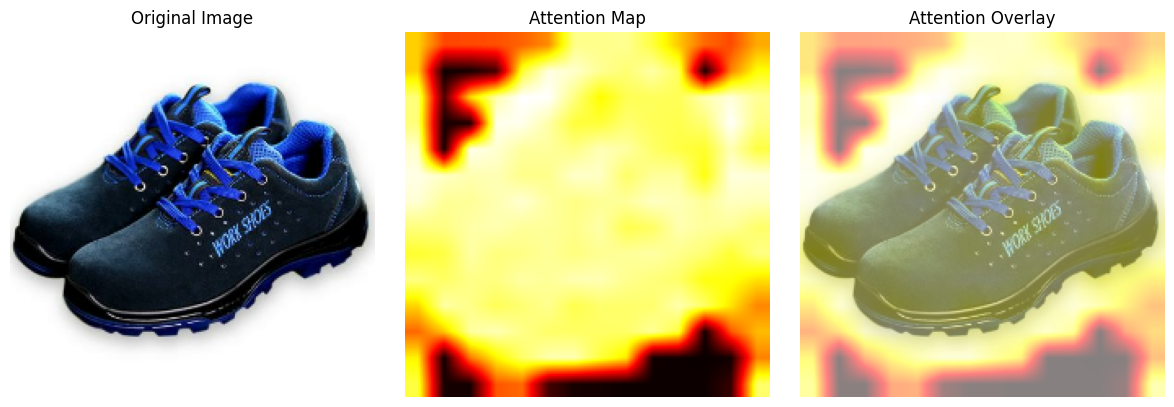

In [ ]:


# Visualize the attention pattern of the CLS token (first token) to all patches
# This shows which parts of the image the model is focusing on
def visualize_attention(embeddings, image_shape):
    # Get the CLS token embedding
    cls_embedding = embeddings[0, 0, :]
    # Get the patch embeddings
    patch_embeddings = embeddings[0, 1:, :]

    # Compute dot product similarity as a simple attention proxy
    similarity = tf.matmul(
        tf.reshape(cls_embedding, [1, -1]),
        tf.transpose(patch_embeddings)
    ).numpy()[0]

    # Normalize to 0-1 for visualization
    similarity = (similarity - similarity.min()) / (similarity.max() - similarity.min())

    # Reshape to grid
    grid_size = int(math.sqrt(len(similarity)))
    attention_map = similarity.reshape(grid_size, grid_size)

    # Resize to match original image
    attention_map = tf.image.resize(
        tf.expand_dims(tf.expand_dims(attention_map, -1), 0),
        [image_shape[0], image_shape[1]]
    )[0, :, :, 0].numpy()

    return attention_map

# Generate and visualize attention map
attention_map = visualize_attention(embeddings, sample_image.shape)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(attention_map, cmap='hot')
plt.title("Attention Map")
plt.axis("off")

plt.subplot(1, 3, 3)
# Overlay attention on original image
plt.imshow(sample_image)
plt.imshow(attention_map, cmap='hot', alpha=0.5)
plt.title("Attention Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()